In [40]:
import pandas as pd

from plotnine import *

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as rvectors
from rpy2.robjects import pandas2ri

import scipy as sp
import statsmodels as sm

%matplotlib inline
r = ro.r

Activate the pandas conversion for rpy2. See, https://pandas.pydata.org/pandas-docs/stable/r_interface.html

In [41]:
pandas2ri.activate()

Import the R packages that will be used in this analysis.

In [42]:
packageNames = ('afex', 'lsmeans', 'coin', 'ARTool', 'phia')
 
if all(rpackages.isinstalled(x) for x in packageNames):
    have_packages = True
else:
   have_packages = False
 
if not have_packages:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]
 
    if len(packnames_to_install) > 0: 
        utils.install_packages(rvectors.StrVector(packnames_to_install))

In [43]:
lsm  = rpackages.importr('lsmeans')
afex = rpackages.importr('afex') 
coin = rpackages.importr('coin')
art = rpackages.importr('ARTool')
phia = rpackages.importr('phia')

t_test = ro.r('t.test')
friedman_test = ro.r('friedman.test')
wilcox_test = ro.r('wilcox.test')
p_adjust = ro.r('p.adjust')

Set the theme to use in plotnine.

In [44]:
theme_set(theme_xkcd())

In [45]:
df = pd.read_csv("avatars.csv")
df.Subject = df.Subject.astype('category')
df.Sex = df.Sex.astype('category')
df.Avatar = df.Avatar.astype('category')
df.Positives = df.Positives.astype(int)

In [46]:
df.head(10)

,Subject,Sex,Avatar,Positives
0,1,Male,Male,78
1,2,Female,Male,104
2,3,Male,Female,89
3,4,Female,Female,71
4,5,Male,Male,61
5,6,Female,Male,65
6,7,Male,Female,109
7,8,Female,Female,47
8,9,Male,Male,65
9,10,Female,Male,107


In [47]:
df.groupby(['Sex']).describe()

Positives                                                        
           count       mean        std   min    25%   50%     75%    max
Sex                                                                     
Female      30.0  74.166667  24.140513  32.0  62.50  68.5   87.75  149.0
Male        30.0  96.033333  19.460806  61.0  83.25  93.5  109.75  135.0

In [48]:
df.groupby(['Avatar']).describe()

Positives                                                        
           count       mean        std   min    25%   50%     75%    max
Avatar                                                                  
Female      30.0  81.933333  26.122963  32.0  64.00  77.5  103.50  135.0
Male        30.0  88.266667  22.486675  54.0  73.25  84.5  104.75  149.0

Determine how many subjects took part in this experiment?

In [49]:
df.Subject.nunique()

60

In [50]:
df.groupby(['Sex', 'Avatar']).describe()

Positives                                                   \
                  count        mean        std   min   25%    50%    75%   
Sex    Avatar                                                              
Female Female      15.0   63.133333  17.484142  32.0  55.0   64.0   68.5   
       Male        15.0   85.200000  25.310077  54.0  68.0   81.0   98.0   
Male   Female      15.0  100.733333  18.721518  70.0  88.0  104.0  109.5   
       Male        15.0   91.333333  19.663842  61.0  80.5   85.0  108.5   

                      
                 max  
Sex    Avatar         
Female Female  102.0  
       Male    149.0  
Male   Female  135.0  
       Male    126.0

In [51]:
df.groupby(['Sex', 'Avatar']).mean().max()

Positives    100.733333
dtype: float64

In [52]:
groups = df.groupby(['Sex', 'Avatar']).mean().reset_index()

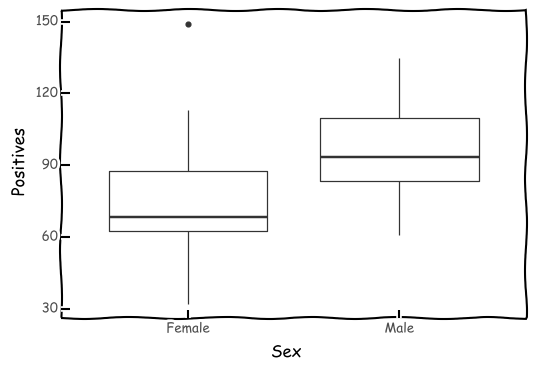

<ggplot: (288461477)>

In [53]:
(
    ggplot(df, aes(x='Sex', y='Positives')) +
    geom_boxplot()
)

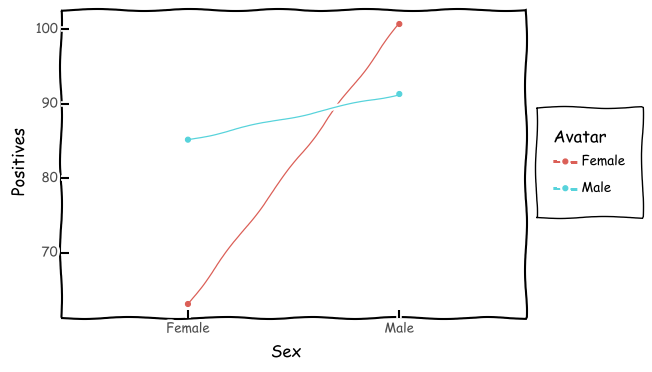

<ggplot: (288446869)>

In [54]:
groups = df.groupby(['Sex', 'Avatar']).mean().reset_index()

(
    ggplot(groups) +
    aes(x='Sex', y='Positives', group = 'Avatar', color='Avatar') +
    geom_line() +
    geom_point()
)

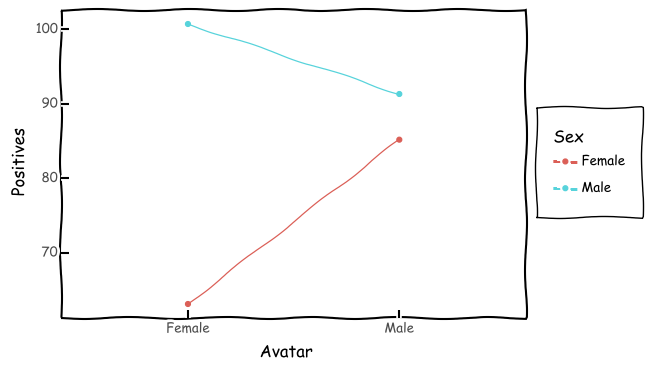

<ggplot: (288226081)>

In [55]:
(
    ggplot(groups) +
    aes(x='Avatar', y='Positives', group = 'Sex', color='Sex') +
    geom_line() +
    geom_point()
)

In [56]:
model = afex.aov_ez(id='Subject', dv='Positives', data=df, between=['Sex', 'Avatar'])
print(r.summary(model))

Anova Table (Type 3 tests)

Response: Positives
           num Df den Df    MSE       F      ges    Pr(>F)    
Sex             1     56 420.86 17.0418 0.233315 0.0001228 ***
Avatar          1     56 420.86  1.4296 0.024893 0.2368686    
Sex:Avatar      1     56 420.86  8.8225 0.136102 0.0043758 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [57]:
groups = df.sort_values('Subject').groupby(['Sex', 'Avatar'])

female_male = groups.get_group(('Female', 'Male'))
female_female =  groups.get_group(('Female', 'Female'))

male_male = groups.get_group(('Male', 'Male'))
male_female =  groups.get_group(('Male', 'Female'))

pvals = [None]*2

# Use scipy independent t-test
pvals[0] = sp.stats.ttest_ind(female_male.Positives, female_female.Positives, equal_var=True)[1]
pvals[1] = sp.stats.ttest_ind(male_male.Positives, male_female.Positives, equal_var=True)[1]
print pvals
pvals_corrected = p_adjust(pvals, method='holm')
print min(pvals_corrected)

# Use R t-test and adjustment.
pvals[0] = t_test(female_male.Positives, female_female.Positives, paired=False, var_equal=True)[2]
pvals[1] = t_test(male_male.Positives, male_female.Positives, paired=False, var_equal=True)[2]
print pvals
pvals_corrected = p_adjust(pvals, method='holm')
print min(pvals_corrected)

# Note, the scipy and R t-test do no return the same results and the
# correct answer according to Coursera is the scipy result.

[0.0096471903902572102, 0.19073468425016099]
0.0192943807805
[<FloatVector - Python:0x1123385a8 / R:0x7ffebdee8478>
[0.010243], <FloatVector - Python:0x1123387e8 / R:0x7ffebdf20328>
[0.190760]]
0.020486015521


In [58]:
df = pd.read_csv("notes.csv")
df.tail(10)

,Subject,Phone,Notes,Order,Words
30,16,Android,Built-in,2,449
31,16,Android,Add-on,1,312
32,17,iPhone,Built-in,1,491
33,17,iPhone,Add-on,2,523
34,18,Android,Built-in,1,259
35,18,Android,Add-on,2,418
36,19,iPhone,Built-in,2,510
37,19,iPhone,Add-on,1,545
38,20,Android,Built-in,2,452
39,20,Android,Add-on,1,433


In [59]:
df.Subject = df.Subject.astype('category')
df.Phone = df.Phone.astype('category')
df.Notes = df.Notes.astype('category')
df.Order = df.Order.astype('category')
df.Words = df.Words.astype(int)

In [60]:
df.Subject.nunique()

20

In [61]:
groups = df.sort_values('Subject').groupby(['Phone', 'Notes'])
groups.mean().max()

Words    533.7
dtype: float64

     Phone     Notes  Words
0  Android    Add-on  388.1
1  Android  Built-in  410.9
2   iPhone    Add-on  504.2
3   iPhone  Built-in  533.7


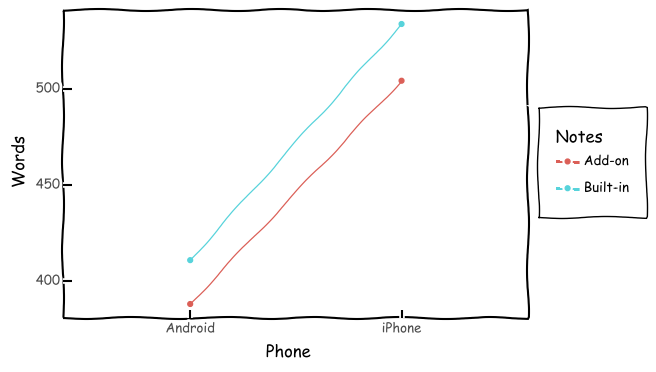

<ggplot: (288176277)>

In [62]:
groups = df.groupby(['Phone', 'Notes']).mean().reset_index()
print(groups)

(
    ggplot(groups) +
    aes(x='Phone', y='Words', group = 'Notes', color='Notes') +
    geom_line() +
    geom_point()
)

     Phone     Notes  Words
0  Android    Add-on  388.1
1  Android  Built-in  410.9
2   iPhone    Add-on  504.2
3   iPhone  Built-in  533.7


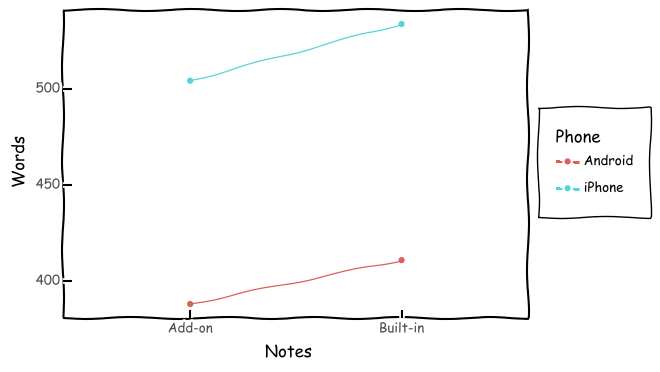

<ggplot: (287508685)>

In [63]:
groups = df.groupby(['Phone', 'Notes']).mean().reset_index()
print(groups)

(
    ggplot(groups) +
    aes(x='Notes', y='Words', group = 'Phone', color='Phone') +
    geom_line() +
    geom_point()
)

In [64]:
model = afex.aov_ez(id='Subject', dv='Words', data=df, between=['Phone'], within=['Order'])
print(r.anova(model))

Anova Table (Type 3 tests)

Response: Words
            num Df den Df    MSE       F     ges    Pr(>F)    
Phone            1     18 3275.4 43.5626 0.56875 3.376e-06 ***
Order            1     18 2735.0  0.5487 0.01368   0.46841    
Phone:Order      1     18 2735.0  3.0644 0.07190   0.09705 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [65]:
model = afex.aov_ez(id='Subject', dv='Words', data=df, between=['Phone'], within=['Notes'])
print(r.anova(model))

Anova Table (Type 3 tests)

Response: Words
            num Df den Df    MSE       F     ges    Pr(>F)    
Phone            1     18 3275.4 43.5626 0.56219 3.376e-06 ***
Notes            1     18 2897.8  2.3598 0.05797    0.1419    
Phone:Notes      1     18 2897.8  0.0387 0.00101    0.8462    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [66]:
groups = df.sort_values('Subject').groupby(['Phone', 'Notes'])

iphone_built_in = groups.get_group(('iPhone', 'Built-in'))
iphone_add_on =  groups.get_group(('iPhone', 'Add-on'))

android_built_in = groups.get_group(('Android', 'Built-in'))
android_add_on =  groups.get_group(('Android', 'Add-on'))

pvals = [None]*2

# Use R t-test and adjustment.
pvals[0] = t_test(iphone_built_in.Words,
                  iphone_add_on.Words, paired=True, var_equal=True)[2]

pvals[1] = t_test(android_built_in.Words,
                  android_add_on.Words, paired=True, var_equal=True)[2]

pvals_corrected = p_adjust(pvals, method='holm')
print pvals_corrected
print min(pvals_corrected)

[1] 0.1960779 0.4675674

0.196077924548


In [67]:
df = pd.read_csv("socialvalue.csv")
df.head(10)

,Subject,Clip,ClipOrder,Social,SocialOrder,Valued
0,1,positive,1,Facebook,1,85
1,1,positive,1,Twitter,2,53
2,1,negative,2,Facebook,2,38
3,1,negative,2,Twitter,1,52
4,2,positive,2,Facebook,2,25
5,2,positive,2,Twitter,1,54
6,2,negative,1,Facebook,1,73
7,2,negative,1,Twitter,2,52
8,3,positive,1,Facebook,1,95
9,3,positive,1,Twitter,2,70


In [68]:
df.Subject = df.Subject.astype('category')
df.Clip = df.Clip.astype('category')
df.ClipOrder = df.ClipOrder.astype('category')
df.Social = df.Social.astype('category')
df.SocialOrder = df.SocialOrder.astype('category')
df.Valued = df.Valued.astype(int)

In [69]:
df.Subject.nunique()

16

In [70]:
groups = df.groupby(['Clip', 'Social']).mean().reset_index()
print(groups.max())

Clip      positive
Social     Twitter
Valued       68.75
dtype: object


       Clip    Social   Valued
0  negative  Facebook  46.3125
1  negative   Twitter  55.5625
2  positive  Facebook  68.7500
3  positive   Twitter  58.5625


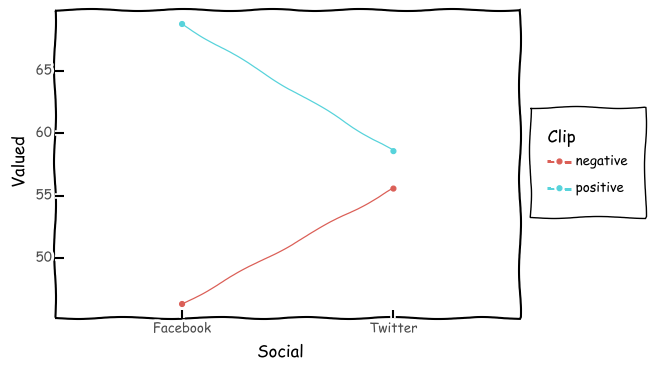

<ggplot: (288702361)>

In [71]:
groups = df.groupby(['Clip', 'Social']).mean().reset_index()
print(groups)

(
    ggplot(groups) +
    aes(x='Social', y='Valued', group = 'Clip', color='Clip') +
    geom_line() +
    geom_point()
)

       Clip    Social   Valued
0  negative  Facebook  46.3125
1  negative   Twitter  55.5625
2  positive  Facebook  68.7500
3  positive   Twitter  58.5625


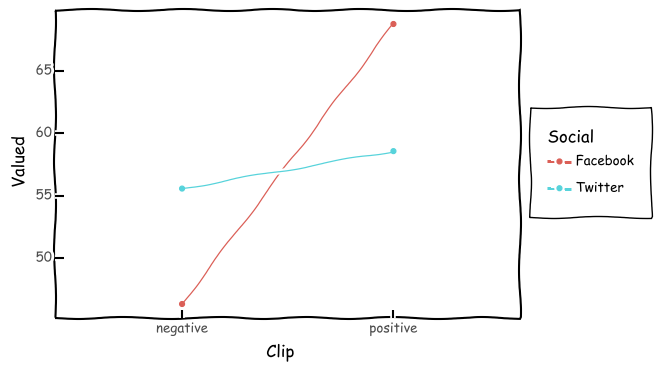

<ggplot: (288720013)>

In [72]:
groups = df.groupby(['Clip', 'Social']).mean().reset_index()
print(groups)

(
    ggplot(groups) +
    aes(x='Clip', y='Valued', group = 'Social', color='Social') +
    geom_line() +
    geom_point()
)

In [73]:
model = afex.aov_ez(id='Subject', dv='Valued', data=df, within=['ClipOrder', 'SocialOrder'])
print(r.summary(model))


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                          SS num Df Error SS den Df         F    Pr(>F)    
(Intercept)           210108      1   2166.6     15 1454.6298 2.373e-16 ***
ClipOrder                479      1   7659.7     15    0.9371    0.3484    
SocialOrder              268      1   4951.1     15    0.8124    0.3817    
ClipOrder:SocialOrder      4      1   3595.7     15    0.0147    0.9052    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [74]:
model = afex.aov_ez(id='Subject', dv='Valued', data=df, within=['Clip', 'Social'])
print(r.summary(model))


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                SS num Df Error SS den Df         F    Pr(>F)    
(Intercept) 210108      1   2166.6     15 1454.6298 2.373e-16 ***
Clip          2588      1   5550.0     15    6.9953   0.01838 *  
Social           4      1   3595.7     15    0.0147   0.90522    
Clip:Social   1511      1   3708.0     15    6.1136   0.02587 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [75]:
groups = df.sort_values('Subject').groupby(['Social', 'Clip'])

facebook_positive = groups.get_group(('Facebook', 'positive'))
facebook_negative =  groups.get_group(('Facebook', 'negative'))

twitter_positive = groups.get_group(('Twitter', 'positive'))
twitter_negative =  groups.get_group(('Twitter', 'negative'))

pvals = [None]*2

# Use R t-test and adjustment.
pvals[0] = t_test(facebook_positive.Valued,
                  facebook_negative.Valued, paired=True, var_equal=True)[2]

pvals[1] = t_test(twitter_positive.Valued,
                  twitter_negative.Valued, paired=True, var_equal=True)[2]

pvals_corrected = p_adjust(pvals, method='holm')
print pvals_corrected
print min(pvals_corrected)

[1] 0.04077153 0.06482275

0.0407715291474


In [76]:
model = art.art(ro.Formula('Valued ~ Clip*Social + (1|Subject)'), data=df)
print(r.anova(model))

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df) 
Model: Mixed Effects (lmer)
Response: art(Valued)

                     F Df Df.res     Pr(>F)    
1 Clip        17.13224  1     45 0.00015089 ***
2 Social       0.49281  1     45 0.48629341    
3 Clip:Social 11.31751  1     45 0.00157736  **
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 



In [77]:
print phia.testInteractions(art.artlm(model, 'Clip:Social'), pairwise=ro.StrVector(['Clip', 'Social']), adjustment="holm")

Chisq Test: 
P-value adjustment method: holm
                                      Value Df  Chisq Pr(>Chisq)    
negative-positive : Facebook-Twitter -29.25  1 11.318  0.0007678 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



# References

1. [Visualizing Interaction Effects with ggplot2](https://sebastiansauer.github.io/vis_interaction_effects/)
2. [Plotnine is the best Python implementation of R's ggplot2](http://pltn.ca/plotnine-superior-python-ggplot/)
3. [Five-ish Steps to Create Pretty Interaction Plots for a Multi-level Model in R](https://quantdev.ssri.psu.edu/tutorials/five-ish-steps-create-pretty-interaction-plots-multi-level-model-r)
4. [Make It Pretty: Plotting 2-way Interactions with ggplot2](https://sakaluk.wordpress.com/2015/08/27/6-make-it-pretty-plotting-2-way-interactions-with-ggplot2/)
5. [ARTool](http://depts.washington.edu/madlab/proj/art/)

# Answers

1. A 2 × 2 between-subjects design with factors for Sex (M, F) and Avatar (M, F).
2. 60
3. 100.73
4. Yes
5. No
6. 17.04
7. Main effect of Sex, Sex x Avatar interaction
8. 0.0193
9. Women made significantly more positive sentiments about male avatars than they did about female avatars.
10. A 2 × 2 mixed factorial design with a between-subjects factor for Phone (iPhone, Android) and a within-subjects factor for Notes (Built-in, Add-on).
11. 20
12. 534
13. No
14. No
15. 0.4684
16. True
17. 43.56
18. 0.1961
19. None of the above.
20. Wrong: None of the above. -> A 2 × 2 within-subjects design with factors for Clip (positive, negative) and Social (Facebook, Twitter). -> A 2 × 2 mixed factorial design with a within-subjects factor for Clip (positive, negative) and a between-subjects factor for Social (Facebook, Twitter).
21. 16
22. 68.75
23. No
24. Yes
25. 0.3484
26. 7.00
27. 0.0408
28. On Facebook, people valued significantly more posts after seeing a positive film clip than a negative film clip.
29. 17.13
30. True
31. 11.32
32. True